In [ ]:
#Main Script for applying autoencoder based HiTS, AHiTS, LSTM, SINDy scheme for PDEs
### This is a comparative study of various schemes
#Asif Hamid Bhat # 06-04-2023

In [280]:
# clear ram
# import torch
# with torch.no_grad():
#     torch.cuda.empty_cache()
# %reset

### Load libraries

In [38]:
########## imports  ##############
import os
import time
import sys
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import pickle
from torch.nn.functional import normalize

import warnings
warnings.filterwarnings('ignore')
# Path for various functions
module_path= os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
criterion = torch.nn.MSELoss(reduction='none')
import ResNet as net
from utils import *
from Autoencoder import *

In [39]:
# paths
noise = 0.0 
system = 'KS'  
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path_to_result=os.path.join('../results/', system)
# path=os.path.join('../aehitsResults/KS/data', system)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'

In [40]:
model_dir,data_dir

('../models/KS', '../data/KS')

#### LOAD DATA

In [41]:
train_data = torch.load(data_dir + "/train_data.pt")
train_data=train_data[:10,:,:]
val_dataALL = torch.load(data_dir + "/val_data.pt")
test_dataALL = torch.load(data_dir + "/test_data.pt")
# train_data=train_data.transpose(1, 2)
# train_data=train_data[:,:-1,:]
# val_data=val_data[:,:-1,:]
# test_dataALL=test_dataALL[:,:-1,:]

In [42]:
test_dataALL.shape,train_data.shape,val_dataALL.shape

(torch.Size([5, 5121, 120]),
 torch.Size([10, 5121, 120]),
 torch.Size([5, 5121, 120]))

In [43]:
# load data
# train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
# val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_dataALL.shape[0]
n_test = test_dataALL.shape[0]
train_data=torch.tensor(train_data).to(torch.float32)
# train_data = train_data
# sets=train_data.shape[0]
# dataloader=torch.utils.data.DataLoader(x, batch_size=sets)
train_data.shape,test_dataALL.shape,val_dataALL.shape

(torch.Size([10, 5121, 120]),
 torch.Size([5, 5121, 120]),
 torch.Size([5, 5121, 120]))

### define AUTOENCODER model

In [46]:
input_size=test_dataALL.shape[2]
hidden_size=8
L1=120 # 100,100,100 for FHN & 120,120,100 for KS
L2=120
L3=100
modelAE = AE(L1,L2,L3,input_size=input_size, hidden_size=hidden_size).to(device)
# modelAE.train(model1, dataloader, num_epochs=5000, learning_rate=1e-3)

### load autoencoder model

In [47]:
model_path=model_dir+'/AE_{}.pt'.format(hidden_size) ### for fhn NEW,
# model_path='../models/FHN/AE_{}.pt'.format(hidden_size) #for FHN
# model_path='../models/KS/AE2_{}_{}.pt'.format(hidden_size,n_train)
# model_path='../models/KS/KStest.pt'
model_state_dict = torch.load(model_path)
modelAE.load_state_dict(model_state_dict)

<All keys matched successfully>

In [48]:
T1=train_data.shape[1]
T2=2*T1
T3=3*T1
T4=4*T1
T5=5*T1
T7=7*T1
T10=10*T1

In [49]:
### testing data size
t_test=T1#test_dataALL.shape[1]#T5 #(T1+1),(T10)
test_data=test_dataALL[:,:t_test,:]#.reshape(4,5120,202)
val_data=val_dataALL[:,:t_test,:]#.reshape(4,5120,202)
test_data.shape,val_data.shape,t_test

(torch.Size([5, 5121, 120]), torch.Size([5, 5121, 120]), 5121)

In [50]:
# Generate some random test data
idx=0
test_dataAE = torch.tensor(test_data[:,:,:]).to(torch.float32).to(device)
#test_data=normalize(test_data)
# Encode the test data
AEstart_time=time.time()
encoded = modelAE.encoder(test_dataAE)
# Decode the encoded data
#decoded = modelAE.decoder(encoded)
AEpred= modelAE.decoder(encoded).cpu().detach().numpy()
# AEpred=modelAE(test_dataAE).cpu().detach().numpy()
# AEpred=AEpred.cpu().detach().numpy()
# Print the original and reconstructed data
# print('Original:', test_data)
# print('Reconstructed:', decoded)
AEend_time=time.time()
test_dataAE=test_dataAE.cpu().detach().numpy()
AE_time=AEend_time-AEstart_time
#t=np.linspace(1,512*6,0.01)
# plt.plot(test_dataAE[idx,:,10],'k',lw=2)
# plt.plot(AEpred[idx,:,10],'r--',lw=2)
# # plt.plot(test_data[:,100:],'k',lw=2)
# # plt.plot(pred[:,100:],'r--',lw=2)
# plt.show()

In [51]:
AE_time

0.008276939392089844

In [52]:
# z=encoded.cpu().detach().numpy()
# plt.plot(z[0,:,:])
# plt.show()

In [53]:
#fig, (ax1) = plt.subplots(figsize=(50, 20), ncols=1)
#pos = ax1.imshow(cmap='Blues', interpolation='none')
#fig.colorbar(pos, ax=ax1)
#a=ax1.imshow(np.abs(test_data[:,100:].T-pred[:,100:].T))
#fig.colorbar(a)

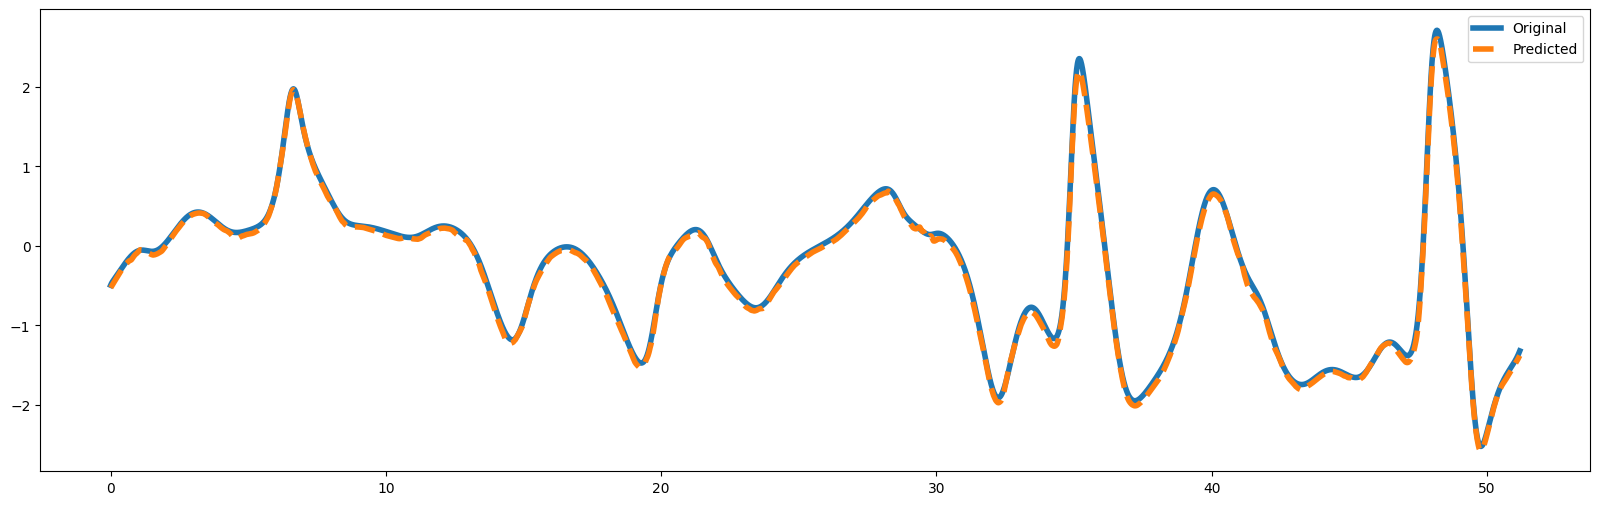

In [54]:
# #plt.figure(size=100)
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(test_data[:,:100].T)
# plt.show()
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(pred[:,:100].T)
# plt.show()
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(np.abs(test_data[:,:100].T-pred[:,:100].T))
# fig.colorbar
# plt.show()
dt=0.01
n_steps=test_dataAE.shape[1]-1
tAE=np.linspace(0,(n_steps-1)*dt, n_steps+1)
fig = plt.figure(figsize=(20, 6))
AE1=test_dataAE[idx,:,0]
AE1_pred=AEpred[idx,:,0]
plt.plot(tAE,AE1,linewidth=4)
#plt.show()
plt.plot(tAE,AE1_pred,'--',linewidth=4)
legend=['Original','Predicted']
plt.legend(legend)
plt.show()

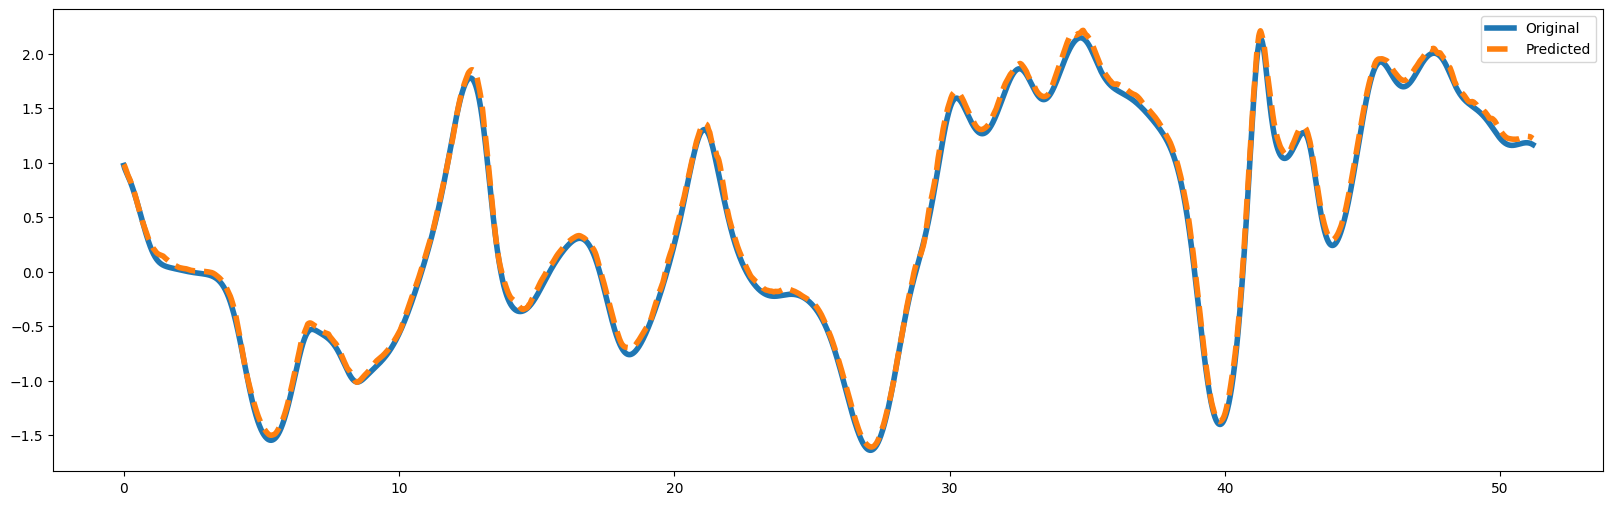

In [55]:
d=50
fig = plt.figure(figsize=(20, 6))
AE2=test_dataAE[idx,:,d]
AE2_pred=AEpred[idx,:,d]
plt.plot(tAE,AE2,linewidth=4)
#plt.show()
plt.plot(tAE,AE2_pred,'--',linewidth=4)
legend=['Original','Predicted']
plt.legend(legend)
plt.show()

In [56]:
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
autoencoder_output=AEpred
# err=norm(test_dataAE-AEpred)/norm(test_dataAE)
# mse_ae=mean_squared_error(test_dataAE.reshape(test_dataAE.shape[0]*test_dataAE.shape[1],test_dataAE.shape[2])
#      ,autoencoder_output.reshape(autoencoder_output.shape[0]*autoencoder_output.shape[1],autoencoder_output.shape[2]))
#err1=norm(test_data[:100]-pred[:100])/norm(test_data[:100])
#err2=norm(test_data[100:]-pred[100:])/norm(test_data[100:])
mse_ae=criterion(torch.tensor(test_dataAE).float(), torch.tensor(autoencoder_output).float()).mean(-1)
MSE_AE=mse_ae.mean(0)
mse_ae=mse_ae.mean()
mse_ae#,err1,err2

tensor(0.0010)

In [57]:
# plt.plot(mse_ae1.mean(-1))
# plt.show()

In [58]:
# msAE=criterion(torch.tensor(test_dataAE).float(), torch.tensor(autoencoder_output).float()).mean(-1)
#msAE.mean()

In [59]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# # Plot the first subplot
# im1=axs[0].imshow(test_dataAE[idx,:,:].T, aspect='auto')
# axs[0].set_title('Ground truth')

# # Plot the second subplot
# im2=axs[1].imshow(AEpred[idx,:,:].T, aspect='auto')
# axs[1].set_title('Autoencoder output')

# # Add a title to the entire figure
# fig.suptitle('Comparison between autoencoder output and ground truth')
# fig.colorbar(im1, ax=axs[0])
# fig.colorbar(im2, ax=axs[1])
# # Show the plot
# plt.show()

In [60]:
# fig = plt.figure(figsize=(20, 6))
# plt.imshow(np.abs(test_dataAE[idx,:,:].T-AEpred[idx,:,:].T), aspect='auto')
# cbar = plt.colorbar()
# plt.show()

In [61]:
#phase potrait
# plt.plot(AE1[100:], AE2[100:], linewidth=3,label='true')
# plt.plot(AE1_pred, linewidth=3,label='true')
# plt.plot(AE2_pred, linewidth=3,label='true')
# # plt.plot(AE1_pred[100:], AE2_pred[100:], '--',linewidth=3, label='learned')
# plt.legend(loc='lower right')
# plt.xlabel('z1')
# plt.ylabel('z2')
# plt.show()

#### Latent dimension 

In [62]:
start=time.time()
z_test=modelAE.encoder(torch.tensor(test_data[:,0,:]).to(torch.float32).to(device))
end=time.time()
AE_time=end-start
AE_time

0.01714611053466797

In [63]:
#Data for latent dimension
z_train=modelAE.encoder(train_data.to(device))
z_valid=modelAE.encoder(torch.tensor(val_data[:,:,:]).to(torch.float32).to(device))
z_test=modelAE.encoder(torch.tensor(test_data[:,:,:]).to(torch.float32).to(device))
# ####z_valid_scaled=normalize(z_valid)
#####z_test_scaled = normalize(z_test)
z_train.shape,z_valid.shape,z_test.shape

(torch.Size([10, 5121, 8]), torch.Size([5, 5121, 8]), torch.Size([5, 5121, 8]))

In [64]:
### sAVE FOR MATLAB TEST
# from scipy.io import savemat
# mdic = {"z_train": z_train.cpu().detach().numpy(), "z_valid": z_valid.cpu().detach().numpy(), "z_test": z_test.cpu().detach().numpy()}
# savemat("matlab_latent.mat", mdic)

In [65]:
# from scipy.io import loadmat
# dataa=loadmat("matlab_latent.mat")
# dataa

In [66]:
# z_test=modelAE.encoder(torch.tensor(test_data[:,:,:]).to(torch.float32).to(device))

In [67]:
# z_train=modelAE.encoder(train_data.to(device))

In [68]:
# z_valid=modelAE.encoder(torch.tensor(val_data).to(torch.float32).to(device))

### hits Variables

In [69]:
tspan=z_train.shape[1]
np.random.seed(2)  # for reproduction
dt = 0.01  #0.001
train_steps = tspan  # at least equal to the largest step size
val_steps =tspan
test_steps = tspan  # t=20
t = np.linspace(0, (train_steps-1)*dt, train_steps)

In [70]:
# fig = plt.figure(figsize=(26, 5))
# # plt.imshow(np.abs(test_dataAE[idx,:,:].T-AEpred[idx,:,:].T), aspect='auto')
# # plt.imshow(z_train[1,:,:].T.cpu().detach().numpy(),aspect='auto')
# plt.plot(z_train[1,:,:].cpu().detach().numpy())
# plt.plot(test_data[1,:,:120].cpu().detach().numpy())
# plt.show()

In [71]:
# load the data to dataset object
datasets = list()
step_sizes = list()
print('Dt\'s: ')
#a=[10,20,30,60,100,200,400,600,800]
for i in range(11):
    step_size = 2**i  #exponential function
    print(step_size)
    print(step_size * dt)
    step_sizes.append(step_size)
    datasets.append(DataSet(z_train, z_valid, z_test, dt, step_size=step_size, n_forward=5))

Dt's: 
1
0.01
2
0.02
4
0.04
8
0.08
16
0.16
32
0.32
64
0.64
128
1.28
256
2.56
512
5.12
1024
10.24


#### load RESNET models

In [72]:
model_dir

'../models/KS'

In [73]:
noise=0.0
models = list() #### FHN Models
for step_size in step_sizes:
    print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
    models.append(torch.load(os.path.join(model_dir, 'modelKS_D{}_h{}.pt'.format(step_size,hidden_size)))) 

loading model_D1_h8.pt
loading model_D2_h8.pt
loading model_D4_h8.pt
loading model_D8_h8.pt
loading model_D16_h8.pt
loading model_D32_h8.pt
loading model_D64_h8.pt
loading model_D128_h8.pt
loading model_D256_h8.pt
loading model_D512_h8.pt
loading model_D1024_h8.pt


In [74]:
# # # load models on CPU
# models = list()
# for step_size in step_sizes:
#     print('load model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size)), map_location='cpu'))

# # fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [75]:
### fhn MODELS
# noise=0.0
# models = list() #### FHN Models
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_h{}_noise{}.pt'.format(step_size, hidden_size,noise)))) ### Best result so far
# noise=0.0
# models = list() #### FHN Models
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'modelKStest_D{}.pt'.format(step_size)))) 
# print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))
#### KS MODELS
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size))))

In [76]:
# 733590/11

In [77]:
#load models
# model_name = 'model_D{}_noise{}.pt'.format(step_size,noise)
# step_sizes=[1,6,36,216,1296]
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size))))
# noise=0.0
# models = list() #### FHN Models
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_h{}_noise{}.pt'.format(step_size, hidden_size,noise)))) ### Best result so far FHN

# fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [78]:
#Data for latent dimension
# z_train=modelAE.encoder(train_data.to(device))
# z_valid=modelAE.encoder(torch.tensor(val_data).to(torch.float32).to(device))
# z_test=modelAE.encoder(torch.tensor(test_data).to(torch.float32).to(device))
# t_test=T10
# n_steps = t_test    #test_data.shape[1] - 1
# n_steps_val=t_test   #val_data.shape[1] - 1
# z_valid=z_valid[:,:n_steps_val+1,:]
# z_test=z_test[:,:n_steps+1,:]
# z_train.shape,z_valid.shape,z_test.shape

In [79]:
# z_test=z_train[:10,:,:]
# t_test=T2

In [80]:
# z_test.shape,z_RN.shape,t_test

In [81]:
test_data.shape[1] - 1

5120

In [82]:
n_steps =test_data.shape[1] - 1   #test_data.shape[1] - 1,t_test
n_steps_val=val_data.shape[1] - 1   #val_data.shape[1] - 1
preds_mse = list()
times = list()
z_hits_uni=[]
print('uniscale forecasting...')
for model in models:
    start = time.time()
    z_RN = model.uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
    z_hits_uni.append(z_RN)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(z_test[:, 1:, :]).float(), z_RN).mean(-1))
print('prediction recorded!')

uniscale forecasting...
prediction recorded!


In [83]:
n_steps_val

5120

In [84]:
times

[0.7979857921600342,
 0.3778846263885498,
 0.19151091575622559,
 0.09460592269897461,
 0.04770946502685547,
 0.027135610580444336,
 0.015596866607666016,
 0.009133338928222656,
 0.005510568618774414,
 0.0037615299224853516,
 0.0029556751251220703]

In [85]:
#preds_mse[9].mean()
#z_RN.shape
# xyz=preds_mse[0]
# xyz.shape
#xyz.mean()
#z_valid.shape,n_steps

### HITS TESTING

In [86]:
z_valid.shape

torch.Size([5, 5121, 8])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

use models 3 - 7.
online time elaspsed is 2.864689588546753


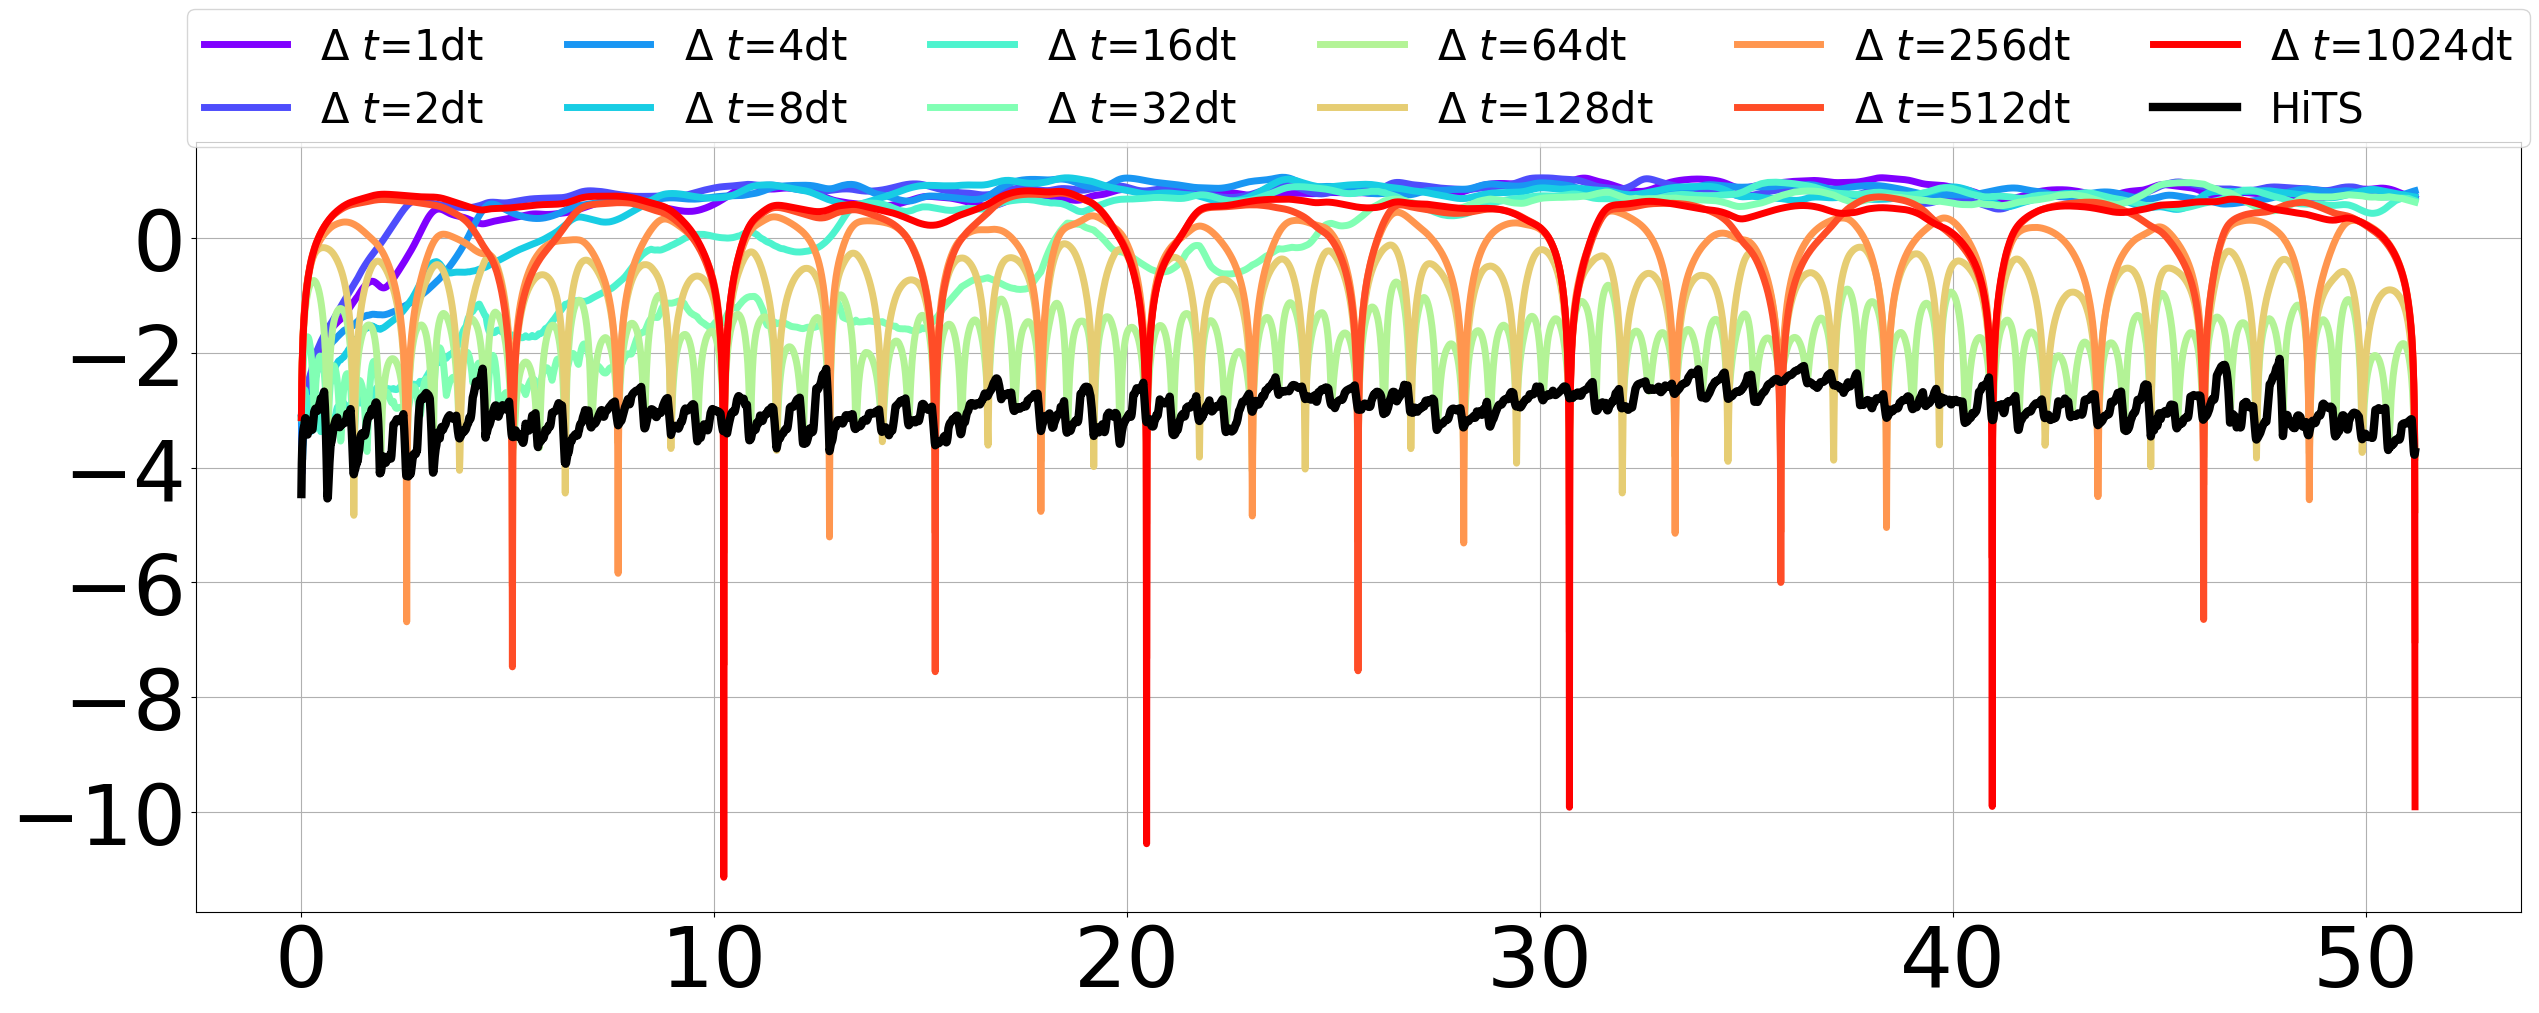

# of params:  23282776


In [87]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5  #1e+5
start_ttime = time.time()  
# choose the largest time step
for i in tqdm(range(len(models))):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[:len(models)-i]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[i:end_idx]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
     
print('use models {} - {}.'.format(start_idx, end_idx))
models1 = models[start_idx:end_idx]

# models1 = models
# models1=[models[i] for i in [4,5,7,9,10]]
# multiscale time-stepping with NN

z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
end_ttime = time.time()
hits_ttime=end_ttime-start_ttime
print('online time elaspsed is',hits_ttime)
multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
t = np.linspace(0, (n_steps-1)*dt, n_steps)
# visualize forecasting error at each time step    
norm_uni=list()
nnerr=[]
ks = list(range(11))
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise=list()
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
#Figure1: error plot
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr.append(mean)
    norm_uni.append(mean.mean())  #mean
    mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [91]:
hits_ttime

2.864689588546753

In [89]:
z_hits.shape

torch.Size([5, 5120, 8])

In [90]:

# # models1 = models
# # models1=[models[i] for i in [4,5,7,9,10]]
# # multiscale time-stepping with NN
# start_time=time.time()
# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# end_time = time.time()
# hits_time=end_time-start_time
# print('online time elaspsed is',hits_time)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# t = np.linspace(0, (n_steps-1)*dt, n_steps)
# # visualize forecasting error at each time step    
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.grid()
# plt.show()

In [742]:
# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# end_time = time.time()
# hits_time=end_time-start_time
# print('online time elaspsed is',hits_time)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# t = np.linspace(0, (n_steps-1)*dt, n_steps)
# # visualize forecasting error at each time step    
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.grid()
# plt.show()

In [743]:
print(multiscale_err.mean())

0.0031595856


In [744]:
n_steps_val,z_valid.shape

(5120, torch.Size([5, 5121, 10]))

In [745]:
# model selections 
# start_idx = 0
# end_idx = len(models)
# best_mse = 1e+5  #1e+5
# start_time = time.time()
# # choose the largest time step
# for i in tqdm(range(len(models))):
#     z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[:len(models)-i]).to(device)
#     mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
#     if mse <= best_mse:
#         end_idx = len(models)-i
#         best_mse = mse

# # choose the smallest time step
# for i in tqdm(range(end_idx)):
#     z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[i:end_idx]).to(device)
#     mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
#     if mse <= best_mse:
#         start_idx = i
#         best_mse = mse
        
# print('use models {} - {}.'.format(start_idx, end_idx))
# models1 = models[start_idx:end_idx]


# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# print(multiscale_err.mean())

In [746]:
# fig = plt.figure(figsize=(30, 10))
# for k in range(2,3):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     # plt.plot(np.log10(mean), '*', linewidth=3, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
#     plt.plot(np.log10(mean), linestyle='-', linewidth=3, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=10, loc='upper center')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.grid()
# plt.show()

## hits testng

#### hits TESTING

In [747]:
# plt.plot(MSE_HITS)
# plt.show()

In [748]:
# MSE_HITS=multiscale_err
# mse_hits=multiscale_err.mean()
# print(mse_hits)

In [749]:
###### Normalised test ###########
# (z_test.shape), z_hits.shape
# z_hits_unscale = z_hits * torch.norm(z_test,dim=1,keepdim=True)
# idx=0;
# fig, axs = plt.subplots(1,3,figsize=(15,5))
# ax=axs[0]
# ax.semilogy(multiscale_preds_mse[idx,:300].cpu().detach().numpy(),'k*')
# ax.set_title('Error')
# ax.grid(True)
# ax=axs[1]
# ax.plot(z_test[idx,:1800,1].cpu().detach().numpy(),'*',linewidth=2)
# ax.plot(z_test[idx,:1800,0].cpu().detach().numpy(),'*',linewidth=2)
# # ax.plot(z_hits_unscale[idx,:300,1].cpu().detach().numpy(),'*',linewidth=2)
# ax.set_title('Original')
# ax.grid(True)
# ax=axs[2]
# ax.plot(z_test_scaled[idx,:300,0].cpu().detach().numpy(),'*',linewidth=2)
# ax.plot(z_hits[idx,:300,0].cpu().detach().numpy(),'*',linewidth=2)
# ax.set_title('Normalized')
# ax.grid(True)
# plt.show()

# (z_test_scaled[idx,130,1].cpu().detach().numpy()-z_hits[idx,130,1].cpu().detach().numpy())**2

In [750]:
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t[:-1], np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t[:-1], np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.show()

In [751]:
# mse_hits=multiscale_err.mean()
# print(mse_hits)

In [752]:
# idx=0
# z1=0
# n_steps=z_test.shape[1]-1
# t=np.linspace(0,(n_steps-1)*dt, n_steps)
# fig = plt.figure(figsize=(20, 6))
# zt=z_test[idx,1:n_steps+1,z1].cpu().detach().numpy()
# zhits=z_hits[idx,0:n_steps,z1].cpu().detach().numpy()
# plt.plot(t,zt,linewidth=4)
# #plt.show()
# plt.plot(t,zhits,'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [753]:
# idx=0
# z1=0
# tt=4000
# n_steps=z_test.shape[1]-1
# t=np.linspace(0,(n_steps-1)*dt, n_steps)
# zt=z_test[idx,1:n_steps+1,:].cpu().detach().numpy()
# zhits=z_hits[idx,0:n_steps,:].cpu().detach().numpy()
# plt.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1],linewidth=3,projection='3d')
# #plt.show()
# # plt.plot(zhits[:,0],zhits[:,1],'--',linewidth=3)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [754]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

# ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
# ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("zAE vs zhits")

# plt.show()

In [755]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

# ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
# ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("zAE vs zhits")

# plt.show()

In [756]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

# ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
# ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("zAE vs zhits")

# plt.show()

In [757]:
# from numpy.linalg import norm
# # fig = plt.figure(figsize=(20, 6))
# # error=np.abs(z_test[:,1:,:].cpu().detach().numpy()-z_hits.cpu().detach().numpy())
#err=norm(z_test[:,1:,:].cpu().detach().numpy()-z_hits.cpu().detach().numpy())/norm(z_test[:,1:,:].cpu().detach().numpy())
# print(multiscale_err.mean())
# plt.plot(error)
# plt.show()
#err

In [758]:
# y_hits.shape

In [34]:
MSE_HITS=multiscale_err
mse_hits=multiscale_err.mean()
print(mse_hits)

0.0014709121


In [35]:
startt=time.time()
y_hits=modelAE.decoder(torch.tensor(z_hits).to(device))
endt=time.time()
ytime=endt-startt
aehits_mse=criterion(torch.tensor(test_data[:,1:,:]).to(device).float(), torch.tensor(y_hits).float()).mean(-1)
aehits_mse=aehits_mse.cpu().detach().numpy()
aehits_mse=aehits_mse.mean(0)

In [37]:
ytime

0.0175321102142334

In [36]:
aehits_mse.mean()

0.00013729153

In [762]:
# aehits_mse.mean(2).mean(0).mean()

In [763]:
# aehits_mse.mean(-1).mean()

In [764]:
# for testing data
y_hits_test=modelAE.decoder(torch.tensor(z_hits).to(device))
aehits_mse_test=criterion(torch.tensor(test_data[:,1:,:]).to(device).float(), torch.tensor(y_hits_test).float())
aehits_mse_test=aehits_mse_test.mean(2).mean(0).cpu().detach().numpy()
aehits_mse_test.mean()

0.0014211268

In [765]:
# aehits_mse_test.shape

In [766]:
# aehits_mse,aehits_mse_test.mean()

In [767]:
ytime,AE_time,hits_ttime

(0.0014338493347167969, 0.0008792877197265625, 3.0324079990386963)

In [768]:
AEhits_time=ytime+AE_time+hits_ttime
print(AEhits_time)

3.0347211360931396


In [769]:
# AEhits_timeErr={"aehits_mse":aehits_mse,'AEhits_time':ytime}
# AEhits_timeErr="AEhits_timeErr.pickle"
# with open(path+AEhits_timeErr, "wb") as file:
#     pickle.dump(AEhits_timeErr, file)

In [770]:
# with open("aehits_out", "wb") as fp:
#     pickle.dump(y_hits, fp)

In [771]:
# t_test=t_test+1

In [772]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')
# u=test_data[idx,1:t_test+1,0].cpu().detach().numpy()
# v=test_data[idx,1:t_test+1,50].cpu().detach().numpy()
# uhits=y_hits[idx,:t_test,0].cpu().detach().numpy()
# vhits=y_hits[idx,:t_test,50].cpu().detach().numpy()
# ax.plot(np.linspace(0,1,n_steps),u,v, lw=2)
# ax.plot(np.linspace(0,1,n_steps),uhits,vhits,'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("output aehits Attractor")

# plt.show()

In [773]:
y_hits.shape

torch.Size([5, 5120, 120])

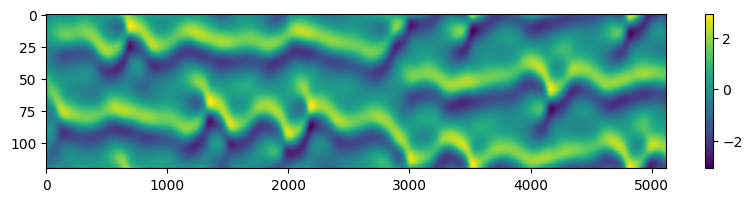

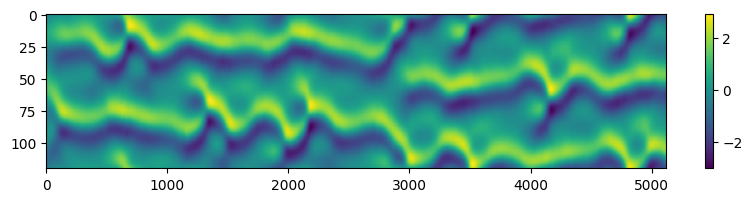

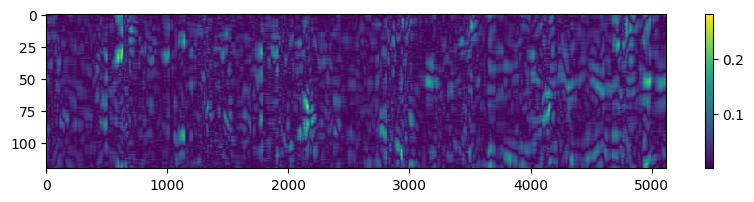

In [774]:
#Final output
idx=0
b=50
yp=y_hits.cpu().detach().numpy()

# err=norm(test_data[:,1:,:]-yp)/norm(test_data[:,1:,:])
# print(err)
fig = plt.figure(figsize=(10, 2))
plt.imshow(test_data[idx,1:,:].T, aspect='auto')
plt.colorbar()
# plt.imshow(test_data[idx,1:T1,:],'k',lw=2)
plt.show()
fig = plt.figure(figsize=(10, 2))
plt.imshow(yp[idx,:,:].T, aspect='auto')
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10, 2))
plt.imshow(np.abs(test_data[idx,1:,:].T-yp[idx,:,:].T), aspect='auto')
plt.colorbar()
plt.show()
# plt.imshow(yp[idx,:,:],'r--',lw=2)
# plt.plot(test_data[:,100:],'k',lw=2)
# plt.plot(pred[:,100:],'r--',lw=2)

In [775]:
#phase potrait
# d=50
# y1_true=test_data[idx,1:T1,0]
# y1_aehits=yp[idx,:,0]
# y2_true=test_data[idx,1:,d]
# y2_aehits=yp[idx,:,d]
# plt.plot(y1_true, y2_true, linewidth=3,label='true')
# plt.plot(y1_aehits, y2_aehits, '--',linewidth=3, label='learned')
# plt.legend(loc='lower left')
# plt.xlabel('y1')
# plt.ylabel('y2')
# plt.show()

In [776]:
#y_preds=AEpreds.cpu()
# z_test=z_test.cpu()
# z_valid=z_valid.cpu()
# z_test.shape

In [777]:
# z_hits=z_hits.to(device)
# z_test=z_test.to(device)
# z_valid=z_valid.to(device)

In [778]:
# idx=10
# n_steps=z_test.shape[1]-1
# t=np.linspace(0,(n_steps-1)*dt, n_steps)
# fig = plt.figure(figsize=(20, 6))
# # y1=test_data[idx,1:,0]
# # y1_pred=y_preds[idx,:,0].detach().numpy()
# plt.plot(t,test_data[idx,1:,1],linewidth=4)
# #plt.show()
# plt.plot(t,y_preds[idx,:,0].detach().numpy(),'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [779]:
# idx=0
# z1=0
# fig = plt.figure(figsize=(20, 6))
# zahits=z_ahits[:,:,:].cpu().detach().numpy()
# plt.plot(z_test[idx,:,z1].cpu().detach().numpy(),linewidth=4)
# #plt.show()
# plt.plot(zahits[idx,:,z1],'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [780]:
# idx=0
# z1=0
# fig = plt.figure(figsize=(20, 6))
# zahits=z_hits[idx,0:n_steps,z1].cpu().detach().numpy()
# plt.plot(t,zt,linewidth=4)
# #plt.show()
# plt.plot(t,zahits,'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [781]:
#print('steps used: {}'.format(steps_used))

In [782]:
# print(mse_hits,mse_ahits)

In [783]:
#print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [784]:
# y_ahits=modelAE.decoder(torch.tensor(z_ahits).to(device))
# aeAhits_mse=criterion(torch.tensor(test_data[:,1:T1,:]).to(device).float(), torch.tensor(y_ahits[:,1:,:]).float()).mean(-1)
# aeAhits_mse=aeAhits_mse.mean()
# print(aeAhits_mse)

In [785]:
y_hits.shape,test_data.shape

(torch.Size([5, 5120, 120]), torch.Size([5, 5121, 120]))

In [786]:
# #Final output
# idx=0
# b=50
# ypa=y_ahits.cpu().detach().numpy()

# # err=norm(test_data[:,1:,:]-yp)/norm(test_data[:,1:,:])
# # print(err)
# plt.plot(test_data[idx,1:T1,b],'k',lw=2)
# plt.plot(ypa[idx,1:n_steps+1,b],'r--',lw=2)
# # plt.plot(test_data[:,100:],'k',lw=2)
# # plt.plot(pred[:,100:],'r--',lw=2)
# plt.show()

In [787]:
# #phase potrait
# d=50
# y1_true=test_data[idx,1:,0]
# y1_aeAhits=ypa[idx,1:n_steps+1,0]
# y2_true=test_data[idx,1:,d]
# y2_aeAhits=ypa[idx,1:n_steps+1,d]
# plt.plot(y1_true, y2_true, linewidth=3,label='true')
# plt.plot(y1_aeAhits, y2_aeAhits, '--',linewidth=3, label='learned')
# plt.legend(loc='lower left')
# plt.xlabel('y1')
# plt.ylabel('y2')
# plt.show()

### Ouput analysis of one latent dimension

In [788]:
# n_steps =test_data.shape[1] - 1   #test_data.shape[1] - 1,t_test
# n_steps_val=val_data.shape[1] - 1   #val_data.shape[1] - 1
# preds_mse = list()
# times = list()
# z_hits_uni=[]
# print('uniscale forecasting...')
# for model in models:
#     start = time.time()
#     z_RN = model.uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
#     z_hits_uni.append(z_RN)
#     end = time.time()
#     times.append(end - start)
#     preds_mse.append(criterion(torch.tensor(z_test[:, 1:, :]).float(), z_RN).mean(-1))
# print('prediction recorded!')

### For testing data

In [789]:
# for testing data
test_data=torch.tensor(test_data).to(torch.float32).to(device)
preds_AEmse = list()
times = list()
y_AEhits_uni=[]
print('NNTS uniscale forecasting |(output)...')
for z_RN in z_hits_uni:
    y_RN = modelAE.decoder(torch.tensor(z_RN).float()).to(device)
    y_AEhits_uni.append(y_RN)
    preds_AEmse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_RN).mean(-1))
print('prediction recorded!')

NNTS uniscale forecasting |(output)...
prediction recorded!


In [790]:
# for testing data
y_hits_test=modelAE.decoder(torch.tensor(z_hits).to(device))
aehits_mse_test=criterion(torch.tensor(test_data[:,1:,:]).to(device).float(), torch.tensor(y_hits_test).float())
aehits_mse_test=aehits_mse_test.mean(2).mean(0).cpu().detach().numpy()
aehits_mse_test.shape

(5120,)

In [791]:
aehits_mse_test.mean()

0.0014211268

In [792]:
preds_AEmse[0].shape,mean.shape

(torch.Size([5, 5120]), (5120,))

In [793]:
## Plotting

In [794]:
# RN0=preds_AEmse[0].cpu().detach().numpy()
# RN0=RN0[0]
# RN0[1:].mean()

In [795]:
# from decimal import Decimal


In [796]:
# RN0=preds_AEmse[10].cpu().detach().numpy()
# RN0.mean()

In [797]:
# aehits_mse.shape

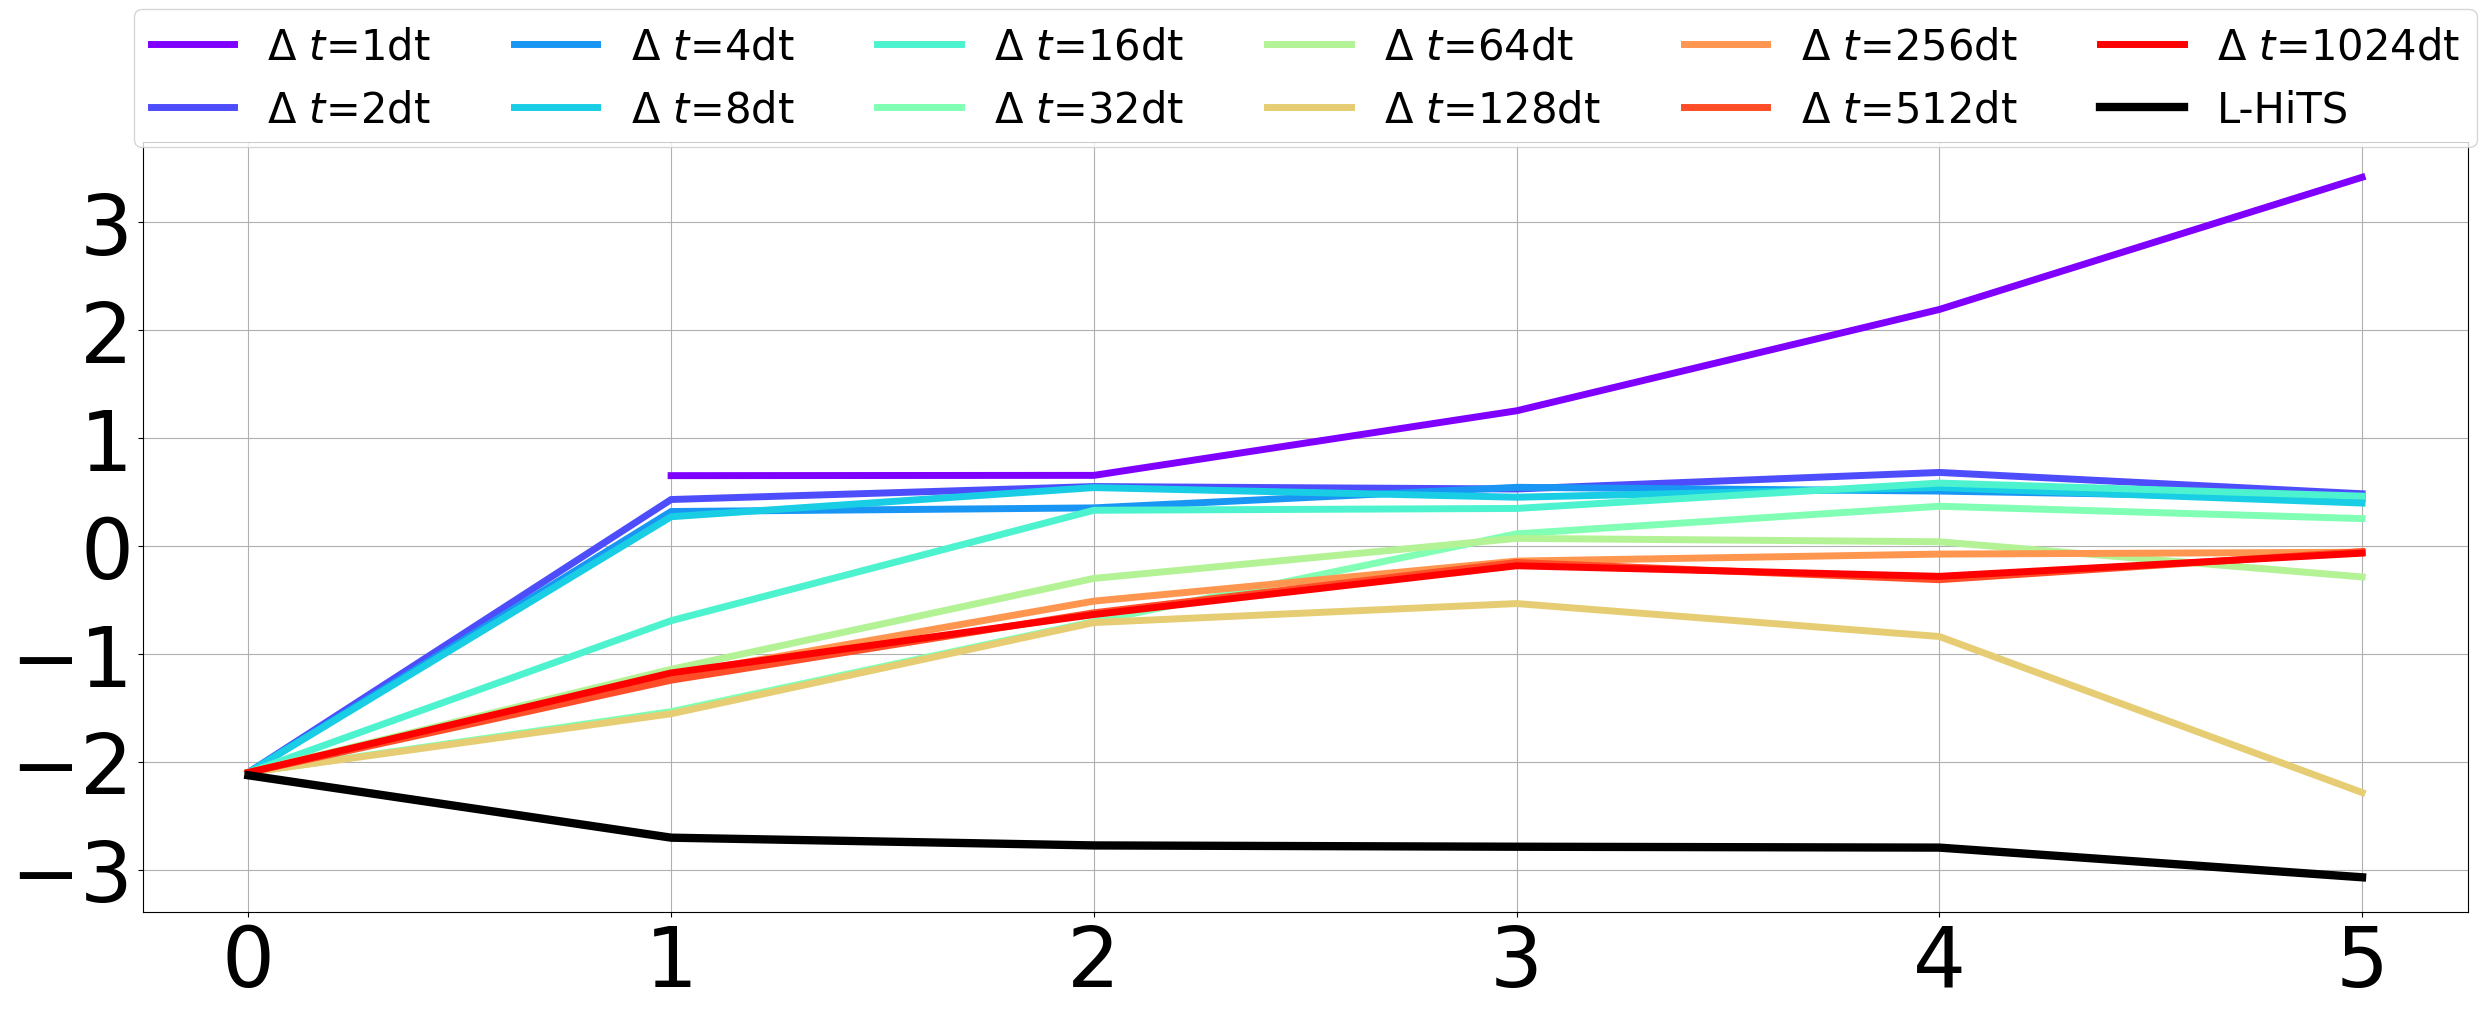

In [798]:
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise=list()
indices=np.arange(0,5120,1000)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
#Figure1: error plot
for k in range(len(preds_AEmse)):
    err = preds_AEmse[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr.append(mean)
    # norm_uni.append(mean.mean())  #mean
    # mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(np.log10(mean[indices]), linestyle='-',color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t, np.log10(aehits_mse), linestyle='-', color='k', linewidth=6, label='L-HiTS')
plt.plot(np.log10(aehits_mse[indices]), linestyle='-', color='k', linewidth=6, label='L-HiTS')

plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()

### For training data

In [799]:
z_train.shape

torch.Size([10, 5121, 10])

In [800]:
n_steps_train=train_data.shape[1]-1
# n_steps =test_data.shape[1] - 1   #test_data.shape[1] - 1,t_test
# n_steps_val=val_data.shape[1] - 1   #val_data.shape[1] - 1
preds_mse_train = list()
z_hits_uni_train=[]
print('uniscale forecasting on training data...')
for model in models:
    z_RN_train = model.uni_scale_forecast(torch.tensor(z_train[:, 0, :]).float(), n_steps=n_steps_train).to(device)
    z_hits_uni_train.append(z_RN_train)
    preds_mse_train.append(criterion(torch.tensor(z_train[:, 1:, :]).float(), z_RN_train).mean(-1))
print('prediction recorded!')

uniscale forecasting on training data...
prediction recorded!


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

use models 0 - 8.


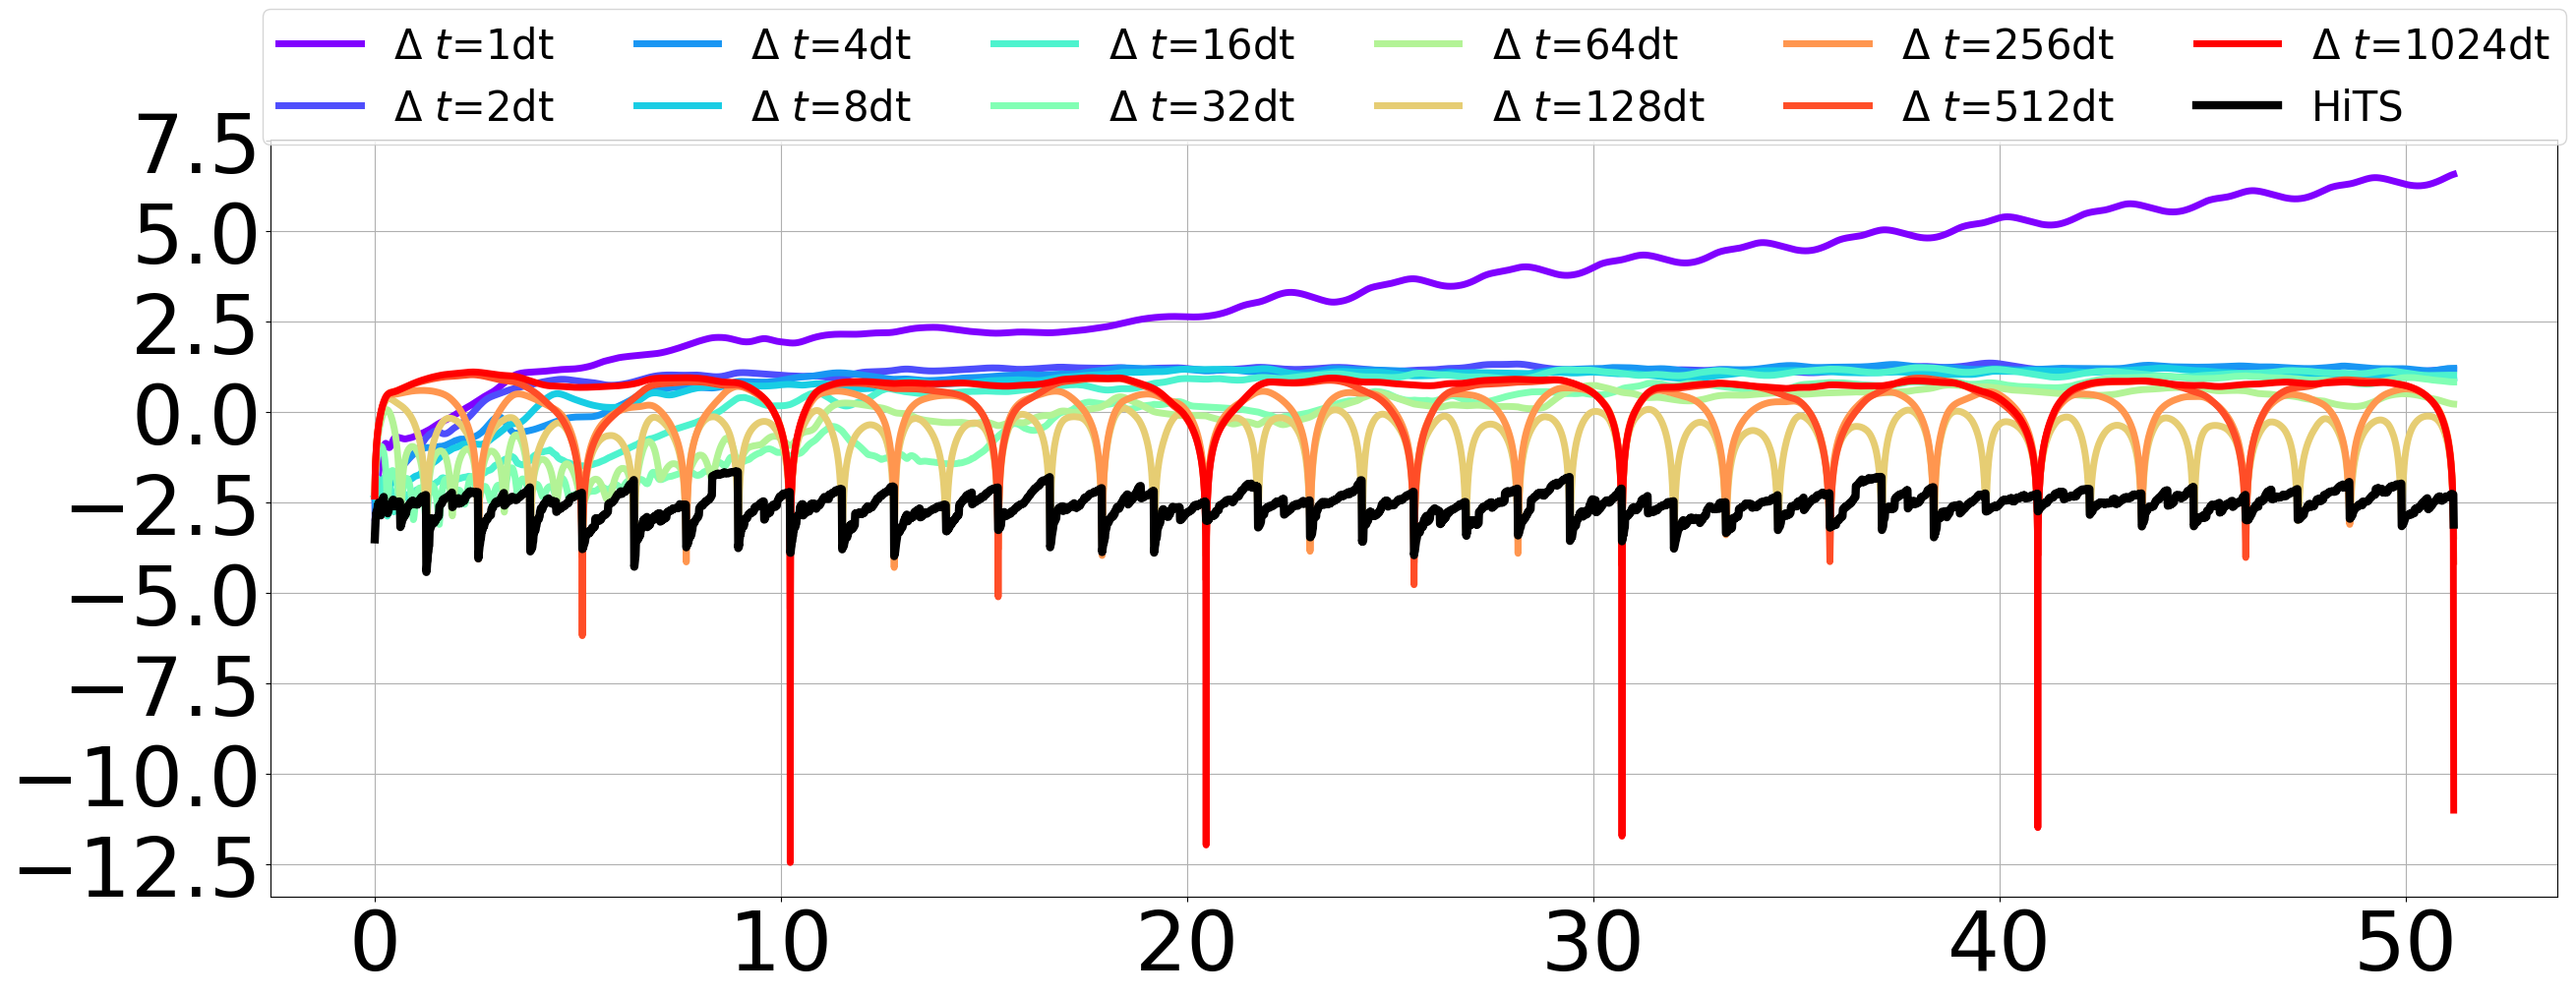

# of params:  23327854


In [801]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5  #1e+5 
# choose the largest time step
for i in tqdm(range(len(models))):
    z_hits_train = net.vectorized_multi_scale_forecast(torch.tensor(z_train[:, 0, :]).float(), n_steps=n_steps_train, models=models[:len(models)-i]).to(device)
    mse = criterion(torch.tensor(z_train[:, 1:, :]).float(), z_hits_train).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_train[:, 0, :]).float(), n_steps=n_steps_train, models=models[i:end_idx]).to(device)
    mse = criterion(torch.tensor(z_train[:, 1:, :]).float(), z_hits_train).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
     
print('use models {} - {}.'.format(start_idx, end_idx))
models1_train = models[start_idx:end_idx]

# models1 = models
# models1=[models[i] for i in [4,5,7,9,10]]
# multiscale time-stepping with NN

z_hits_train = net.vectorized_multi_scale_forecast(torch.tensor(z_train[:, 0, :]).float(), n_steps=n_steps_train, models=models1_train).to(device)
multiscale_preds_mse_train = criterion(torch.tensor(z_train[:, 1:, :]).float(), z_hits_train).mean(-1)
multiscale_err_train = multiscale_preds_mse_train.mean(0).cpu().detach().numpy()
t_train = np.linspace(0, (n_steps_train-1)*dt, n_steps_train)
# visualize forecasting error at each time step    
norm_uni_train=list()
nnerr_train=[]
ks = list(range(11))
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise_train=list()
#Figure1: error plot
for k in range(len(preds_mse_train)):
    err = preds_mse_train[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr_train.append(mean)
    norm_uni_train.append(mean.mean())  #mean
    mean_pointwise_train.append(mean)
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err_train), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [802]:
### for training data
train_data=torch.tensor(train_data.float()).to(device)
preds_AEmse_train = list()
y_AEhits_uni_train=[]
print('NNTS uniscale forecasting for training data(output)...')
for z_RN_train in z_hits_uni_train:
    y_RN_train = modelAE.decoder(torch.tensor(z_RN_train).float()).to(device)
    y_AEhits_uni_train.append(y_RN_train)
    preds_AEmse_train.append(criterion(torch.tensor(train_data[:, 1:, :]).float(), y_RN_train).mean(-1))
print('prediction recorded!')

NNTS uniscale forecasting for training data(output)...
prediction recorded!


In [803]:
train_data.shape

torch.Size([10, 5121, 120])

In [804]:
z_hits_train.shape

torch.Size([10, 5120, 10])

In [805]:
# for training data
y_hits_train=modelAE.decoder(torch.tensor(z_hits_train[:10,:,:]).to(device))
aehits_mse_train=criterion(torch.tensor(train_data[:10,1:,:]).to(device).float(), torch.tensor(y_hits_train).float())
aehits_mse_train=aehits_mse_train.mean(2).mean(0).cpu().detach().numpy()
aehits_mse_train.shape

(5120,)

In [806]:
aehits_mse.mean(),aehits_mse_train.mean()

(0.0014211268, 0.0015365744)

In [807]:
aehits_mse.shape,aehits_mse_train.shape

((5120,), (5120,))

### save results

In [808]:
results = {"aehits_mse_test":aehits_mse,"aehits_mse_train": aehits_mse_train}
filename="/MSE_{}.pickle".format(hidden_size)
with open(path_to_result+filename, "wb") as file:
    pickle.dump(results, file)

In [181]:
# with open(path_to_result+filename, 'rb') as file:
#     FHNmse= pickle.load(file)

In [ ]:
# import pandas as pd
# # Create a dictionary with variable names as keys and values as entries
# datatable = {
#     'Method': ['mse_ae', 'mse_hits', 'aehits_mse'],
#     'MSE error ': [mse_ae.cpu().detach().numpy(), mse_hits, aehits_mse.cpu().detach().numpy()]
# }

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(datatable)

# # Create a table plot using pandas
# table = pd.plotting.table(
#     ax=plt.gca(),
#     data=df,
#     loc='center',
#     cellLoc='center',
#     colWidths=[0.2, 0.2],
#     bbox=[0, 0, 1, 1]
# )

# # Customize the table appearance
# table.set_fontsize(14)
# table.scale(1.2, 1.2)

# # Remove the axis labels and ticks
# plt.axis('off')

# # Save the figure
# tablename='AEhitsmse_table.png'
# plt.savefig(path_to_result+tablename, bbox_inches='tight')

'../results/FHN'

### SAVE Results

In [71]:
encoded.shape,z_hits.shape

(torch.Size([1, 5121, 2]), torch.Size([1, 5120, 2]))

In [72]:
AEpred.shape,y_hits.shape

((1, 5121, 202), torch.Size([1, 5120, 202]))

In [73]:
path

'../aehitsResults/FHN/data/FHN'

In [82]:
# times_error={"error_ind":preds_mse,'cpu_times':times}
# times_errorfile="times_error.pickle"
# with open(path+times_errorfile, "wb") as file:
#     pickle.dump(times_error, file)

In [84]:
# GPUtimes = {"hits_time":AE_time+hits_ttime}
# filename="GPUtimes.pickle"
# with open(path+filename, "wb") as file:
#     pickle.dump(GPUtimes, file)

In [85]:
# mse = {"aehits_mse":aehits_mse,"aelstm_mse": aelstm_mse,"aeRC_mse": aeRC_mse,"aesindy_mse": aesindy_mse}
# filename="mse.pickle"
# with open(path+filename, "wb") as file:
#     pickle.dump(mse, file)

In [79]:
test_data.shape,encoded.shape,z_hits.shape

(torch.Size([5, 5121, 120]),
 torch.Size([5, 5121, 8]),
 torch.Size([5, 5120, 8]))

In [80]:
path

'../aehitsResults/KS/data/KS'

In [177]:
results = {"test_data":test_data,"encoded": encoded,"z_hits": z_hits,"AEpred": AEpred,"y_hits": y_hits,"NNTS_error":preds_mse,'multiscale_err':multiscale_err}
filename="results.pickle"
with open(path+filename, "wb") as file:
    pickle.dump(results, file)

FileNotFoundError: [Errno 2] No such file or directory: '../aehitsResults/FHN/data/FHN/results.pickle'

In [293]:
# file="test_data.pickle"
# with open(path+file, "wb") as file:
#     pickle.dump(test_data, file)

In [294]:
path

'../results/FHN/data/FHN'

### save MSE results as table

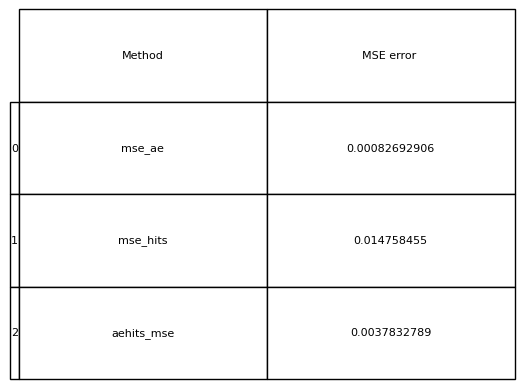

In [83]:
import pandas as pd
# Create a dictionary with variable names as keys and values as entries
datatable = {
    'Method': ['mse_ae', 'mse_hits', 'aehits_mse'],
    'MSE error ': [mse_ae.cpu().detach().numpy(), mse_hits, aehits_mse.cpu().detach().numpy()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(datatable)

# Create a table plot using pandas
table = pd.plotting.table(
    ax=plt.gca(),
    data=df,
    loc='center',
    cellLoc='center',
    colWidths=[0.2, 0.2],
    bbox=[0, 0, 1, 1]
)

# Customize the table appearance
table.set_fontsize(14)
table.scale(1.2, 1.2)

# Remove the axis labels and ticks
plt.axis('off')

# Save the figure
tablename='mse_table.png'
plt.savefig(path+tablename, bbox_inches='tight')


### save computational time results as table

In [104]:
# import pandas as pd
# # Create a dictionary with variable names as keys and values as entries
# datatable = {
#     'Method': ['HiTS', 'LSTM', 'RC','SINDY'],
#     'Computational Time ': [hits_ttime,lstm_time,rc_time,sindy_time]
# }

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(datatable)

# # Create a table plot using pandas
# table = pd.plotting.table(
#     ax=plt.gca(),
#     data=df,
#     loc='center',
#     cellLoc='center',
#     colWidths=[0.2, 0.2],
#     bbox=[0, 0, 1, 1]
# )

# # Customize the table appearance
# table.set_fontsize(14)
# table.scale(1.2, 1.2)

# # Remove the axis labels and ticks
# plt.axis('off')

# # Save the figure
# tablename='cputime_table_5T.png'
# plt.savefig(path+tablename, bbox_inches='tight')
